In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
import statsmodels.api as sm

In [6]:
import duckdb

con = duckdb.connect()

df = con.execute("SELECT * FROM read_csv_auto('/Users/tejapeddi/glm-project/data/train.csv')").df()

print(df.shape)
print(df.head())

(595212, 59)
   id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0              0              0              1              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              0              1              0              0  ...   
4              0              1              0              0  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1           5           8               0   
1           3

In [7]:
df['target'].value_counts()

target
0    573518
1     21694
Name: count, dtype: int64

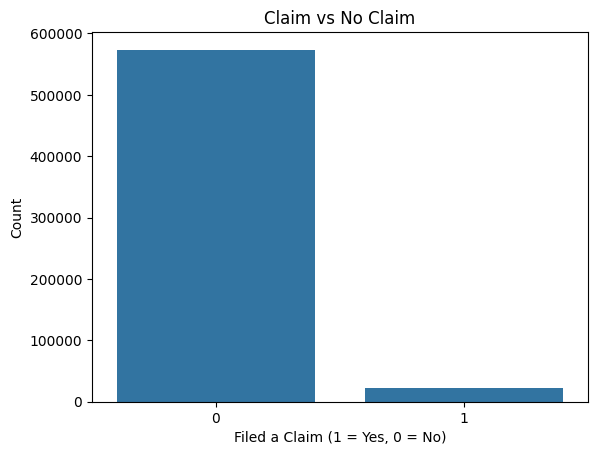

In [8]:
sns.countplot(x='target', data=df)
plt.title('Claim vs No Claim')
plt.xlabel('Filed a Claim (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

In [9]:
missing = (df == -1).sum()
missing[missing > 0]

ps_ind_02_cat       216
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_05_cat    266551
ps_car_07_cat     11489
ps_car_09_cat       569
ps_car_11             5
ps_car_12             1
ps_car_14         42620
dtype: int64

In [12]:
import numpy as np

# Replace -1 with NaN
df = df.replace(-1, np.nan)

# Fill remaining missing values with the column median
df = df.fillna(df.median())

print("New shape:", df.shape)

New shape: (595212, 57)


In [13]:
corr = df.corr()['target'].sort_values(ascending=False)
print(corr)

target            1.000000
ps_car_13         0.053899
ps_car_12         0.038800
ps_ind_17_bin     0.037053
ps_reg_02         0.034800
ps_ind_07_bin     0.034218
ps_reg_03         0.033344
ps_car_04_cat     0.032900
ps_ind_05_cat     0.031124
ps_car_15         0.027667
ps_reg_01         0.022888
ps_ind_01         0.018570
ps_car_01_cat     0.017137
ps_ind_08_bin     0.013147
ps_car_06_cat     0.011537
ps_car_14         0.011161
ps_ind_04_cat     0.009910
ps_ind_03         0.008360
ps_ind_12_bin     0.007810
ps_ind_14         0.007443
ps_car_09_cat     0.006197
ps_car_11_cat     0.006129
ps_ind_02_cat     0.005413
ps_ind_18_bin     0.004555
ps_ind_13_bin     0.002460
ps_ind_11_bin     0.002028
ps_calc_03        0.001907
ps_ind_10_bin     0.001815
ps_calc_01        0.001782
ps_calc_14        0.001362
ps_calc_02        0.001360
ps_calc_10        0.001061
ps_car_10_cat     0.001038
ps_calc_05        0.000771
ps_calc_09        0.000719
ps_calc_16_bin    0.000624
ps_calc_18_bin    0.000552
p

In [14]:
calc_cols = [col for col in df.columns if 'calc' in col]
df = df.drop(columns=calc_cols + ['id'])

print("Final shape:", df.shape)

Final shape: (595212, 36)


In [15]:
con = duckdb.connect()
con.register('insurance', df)

# Test it works
con.execute("SELECT COUNT(*) FROM insurance").df()

,count_star()
0,595212


In [16]:
con.execute("""
    SELECT 
        ps_ind_17_bin,
        COUNT(*) as total_customers,
        SUM(target) as total_claims,
        ROUND(AVG(target) * 100, 2) as claim_rate_pct
    FROM insurance
    GROUP BY ps_ind_17_bin
    ORDER BY claim_rate_pct DESC
""").df()

,ps_ind_17_bin,total_customers,total_claims,claim_rate_pct
0,1,72069,3975.0,5.52
1,0,523143,17719.0,3.39


In [17]:
df.to_csv('/Users/tejapeddi/glm-project/data/train_clean.csv', index=False)
print("Saved!")

Saved!


In [23]:
import pandas as pd
import statsmodels.api as sm

# Reload cleaned data
df = pd.read_csv('/Users/tejapeddi/glm-project/data/train_clean.csv')

# Features and target
X = df.drop(columns=['target'])
y = df['target']

# Add intercept
X = sm.add_constant(X)

# Fit Poisson GLM
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:               595212
Model:                            GLM   Df Residuals:                   595178
Model Family:                 Poisson   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -91635.
Date:                Wed, 25 Feb 2026   Deviance:                   1.3988e+05
Time:                        03:50:26   Pearson chi2:                 5.70e+05
No. Iterations:                   100   Pseudo R-squ. (CS):           0.006388
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.0950      0.110    -28.227

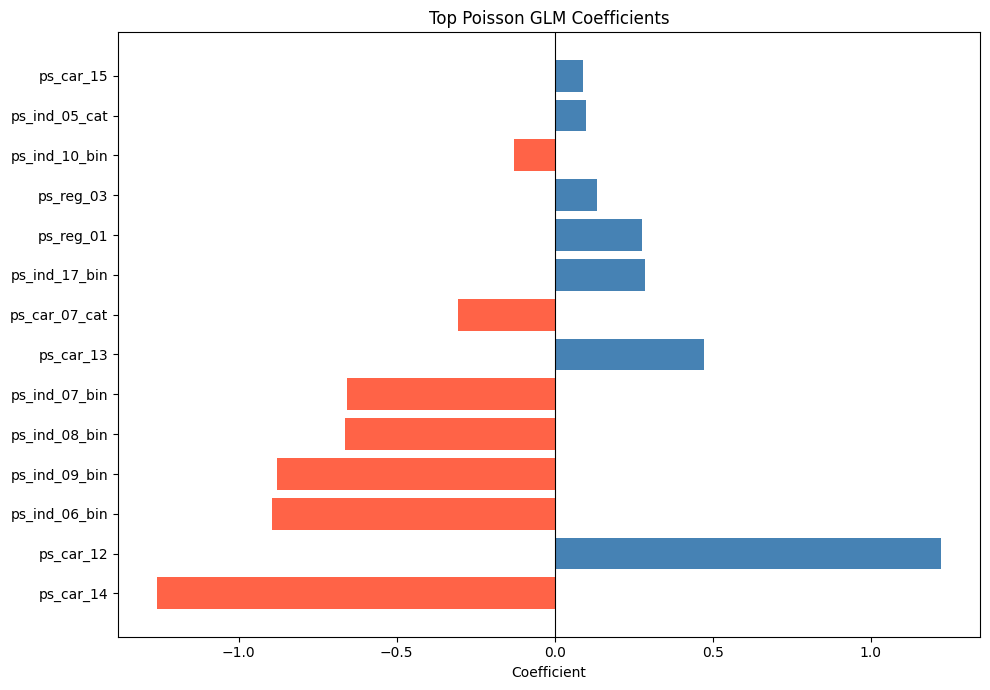

In [25]:
import matplotlib.pyplot as plt
import numpy as np

coef = poisson_results.params.drop('const')
coef_sorted = coef.abs().sort_values(ascending=False).head(14)
coef_vals = poisson_results.params[coef_sorted.index]

plt.figure(figsize=(10, 7))
colors = ['steelblue' if v > 0 else 'tomato' for v in coef_vals]
plt.barh(coef_vals.index, coef_vals.values, color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Coefficient')
plt.title('Top Poisson GLM Coefficients')
plt.tight_layout()
plt.savefig('/Users/tejapeddi/glm-project/report/poisson_coefficients.png')
plt.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Poisson GLM on training data only
poisson_train = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_train_results = poisson_train.fit()

# Predict on test data
y_pred = poisson_train_results.predict(X_test)

# Evaluate
auc = roc_auc_score(y_test, y_pred)
print(f"Out-of-sample AUC: {round(auc, 3)}")

Out-of-sample AUC: 0.623
